In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision


In [2]:
tensot_transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=tensot_transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 320367645.88it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27400066.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 179526293.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23403598.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


In [3]:
class auto_encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(), torch.nn.Linear(128,64),
            torch.nn.ReLU(), torch.nn.Linear(64,36),
            torch.nn.ReLU(), torch.nn.Linear(36,18),
            torch.nn.ReLU(), torch.nn.Linear(18,9))

        self.decoder = torch.nn.Sequential(torch.nn.Linear(9,18),
            torch.nn.ReLU(),
            torch.nn.Linear(18,36),torch.nn.ReLU(),
            torch.nn.Linear(36,64),torch.nn.ReLU(),
            torch.nn.Linear(64,128),torch.nn.ReLU(),
            torch.nn.Linear(128,28*28),
            torch.nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
model = auto_encoder()
loss_F = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

Epoch: 1, Loss: 0.0431
Epoch: 2, Loss: 0.0395
Epoch: 3, Loss: 0.0339
Epoch: 4, Loss: 0.0395
Epoch: 5, Loss: 0.0345
Epoch: 6, Loss: 0.0334
Epoch: 7, Loss: 0.0358
Epoch: 8, Loss: 0.0317
Epoch: 9, Loss: 0.0244
Epoch: 10, Loss: 0.0277


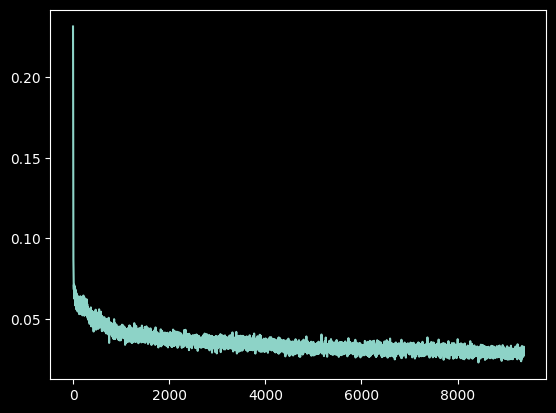

In [5]:
epochs = 10
outputs = []
losses = []

for epoch in range(epochs):
    for ( image,_ ) in data_loader:

        image = image.reshape(-1, 28*28)

        reconstructions = model(image)
        loss = loss_F(reconstructions, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
    outputs.append((epoch, image, reconstructions))
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

plt.style.use('dark_background')
losses = [x.detach().numpy() for x in losses]

plt.plot(losses)

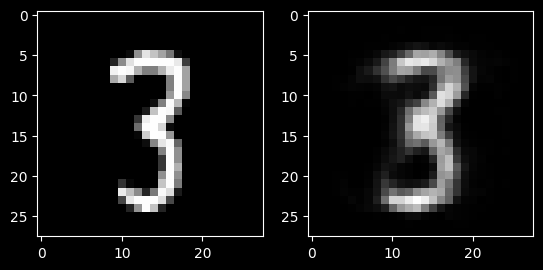

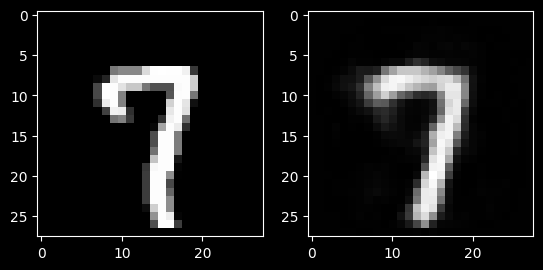

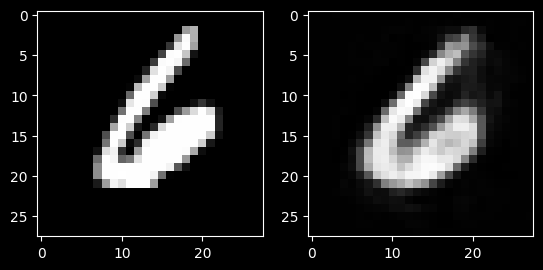

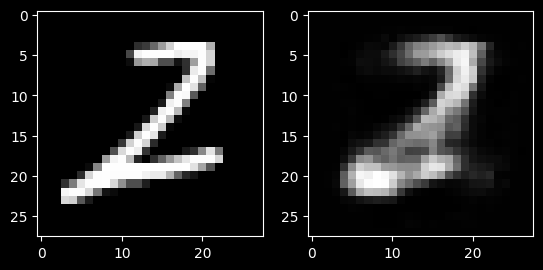

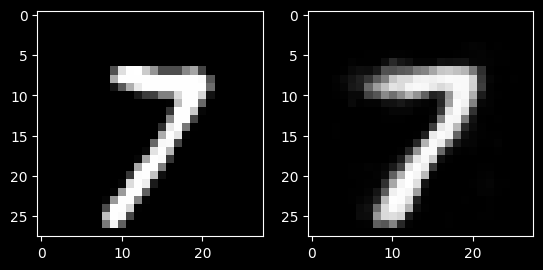

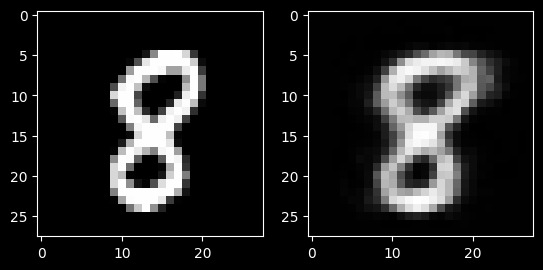

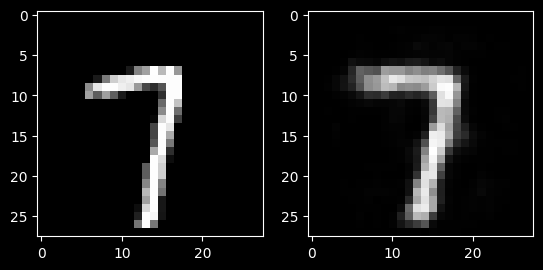

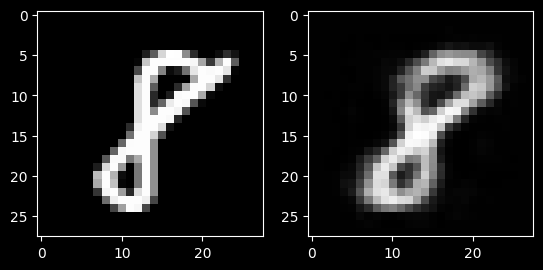

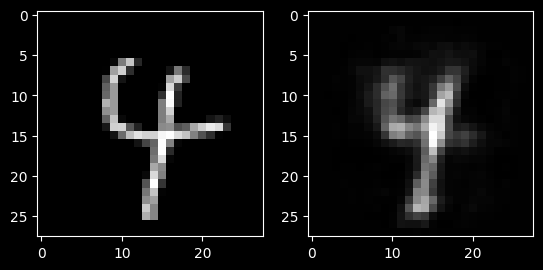

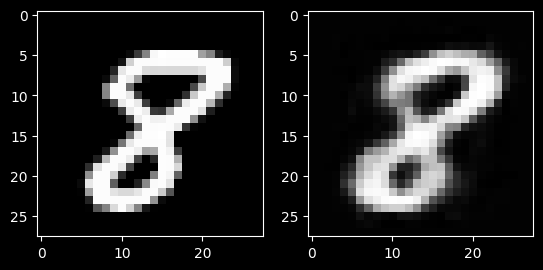

In [6]:
i = 0
for  img, rec in zip(image,reconstructions):
  fig, axs = plt.subplots(1, 2)

  # Reshape the array for plotting
  img = img.reshape(-1, 28, 28)
  rec = rec.reshape(-1, 28, 28)
  rec = rec.detach().numpy()


  # Plot the images
  axs[0].imshow(img[0], cmap='gray')
  axs[1].imshow(rec[0], cmap='gray')
  plt.show()
  i+=1
  if i==10:
    break


In [7]:
class conv_auto_encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(), torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(), torch.nn.Conv2d(32, 64, kernel_size=7))

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=7),
            torch.nn.ReLU(), torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(), torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = conv_auto_encoder().to(device)
loss_F = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)


Epoch: 1, Loss: 0.0819
Epoch: 2, Loss: 0.0740
Epoch: 3, Loss: 0.0736
Epoch: 4, Loss: 0.0776
Epoch: 5, Loss: 0.0721
Epoch: 6, Loss: 0.0741
Epoch: 7, Loss: 0.0646
Epoch: 8, Loss: 0.0724
Epoch: 9, Loss: 0.0707
Epoch: 10, Loss: 0.0711


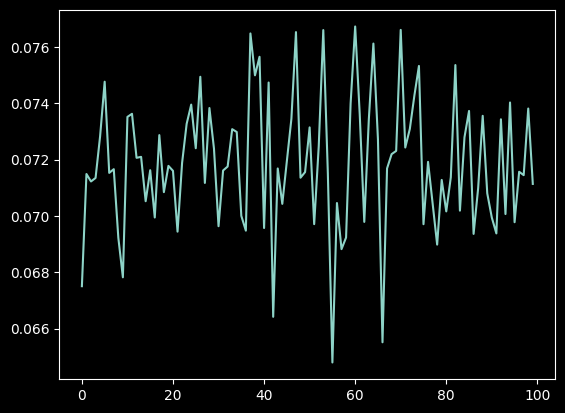

In [9]:
epochs = 10
outputs = []
losses = []

for epoch in range(epochs):
    for ( image,_ ) in data_loader:

        image = image.to(device)
        reconstructions = model(image)
        loss = loss_F(reconstructions, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
    outputs.append((epoch, image, reconstructions))
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

plt.style.use('dark_background')
losses = [x.cpu().detach().numpy() for x in losses]

plt.plot(losses[-100:])

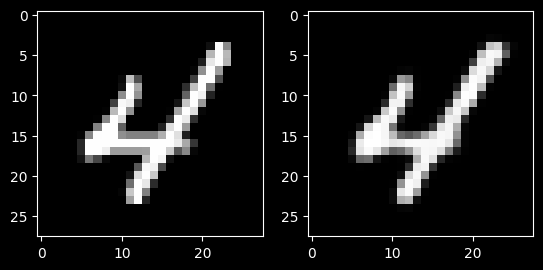

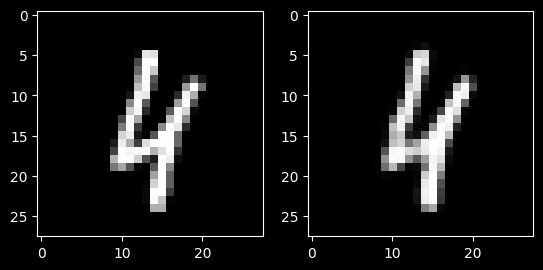

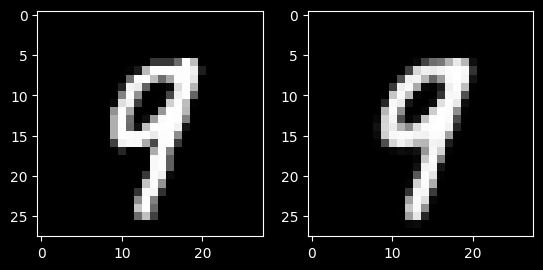

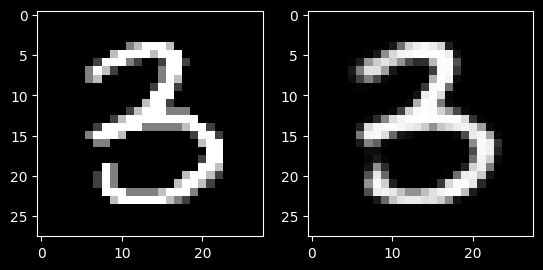

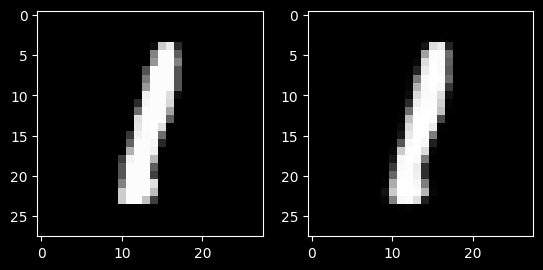

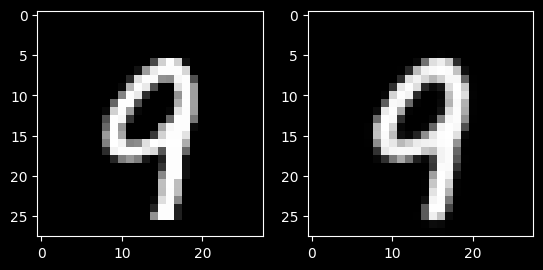

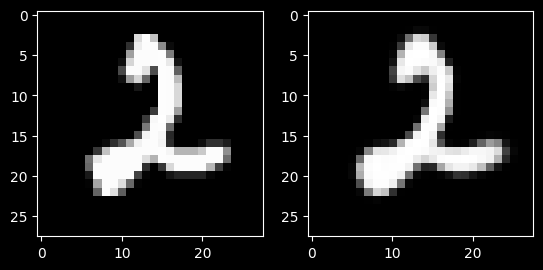

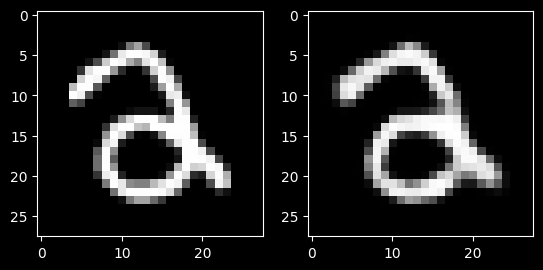

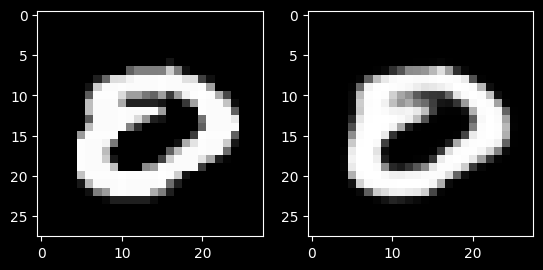

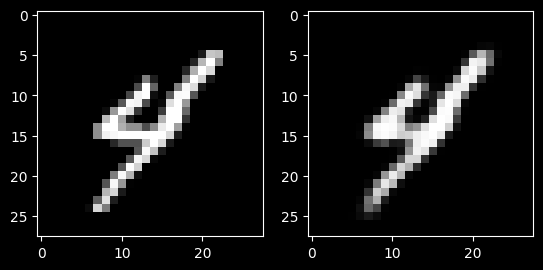

In [10]:
i = 0
for img, rec in zip(image,reconstructions):
    fig, axs = plt.subplots(1, 2)

    # Reshape the array for plotting
    img = img.reshape(-1, 28, 28).cpu().detach().numpy()
    rec = rec.reshape(-1, 28, 28)
    rec = rec.cpu().detach().numpy()


    # Plot the images
    axs[0].imshow(img[0], cmap='gray')
    axs[1].imshow(rec[0], cmap='gray')
    plt.show()
    i+=1
    if i==10:
      break


In [11]:
class var_auto_encoder(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim = 200,z_dim = 20):
        super().__init__()
        #encoder
        self.img2hidden = torch.nn.Linear(input_dim,hidden_dim)
        self.hidden2mean = torch.nn.Linear(hidden_dim,z_dim)
        self.hidden2sima = torch.nn.Linear(hidden_dim,z_dim)

        #decoder
        self.z2hidden = torch.nn.Linear(z_dim,hidden_dim)
        self.hidden2img = torch.nn.Linear(hidden_dim,input_dim)

    def encoder(self,x):
        hidden = torch.relu(self.img2hidden(x))
        mean = self.hidden2mean(hidden)
        sigma = self.hidden2sima(hidden)
        return mean,sigma

    def decoder(self, z):
        hidden = torch.relu(self.z2hidden(z))
        img = torch.sigmoid(self.hidden2img(hidden))
        return img

    def forward(self,x):
        mu,sigma = self.encoder(x)
        epslion = torch.randn_like(sigma)
        z = mu + epslion * sigma
        img_rec = self.decoder(z)
        return img_rec,mu,sigma

if __name__ == "__main__":
    x = torch.randn(4,784)
    model = var_auto_encoder(784,200,20)
    img_rec,mu,sigma = model(x)
    print(img_rec.shape,mu.shape,sigma.shape)

torch.Size([4, 784]) torch.Size([4, 20]) torch.Size([4, 20])


In [12]:
model = var_auto_encoder(784,200,20).to("cuda")
loss_F = torch.nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

Epoch: 1, Loss: 5311.3589
Epoch: 2, Loss: 4730.4238
Epoch: 3, Loss: 4783.0303
Epoch: 4, Loss: 4012.5752
Epoch: 5, Loss: 3856.2622


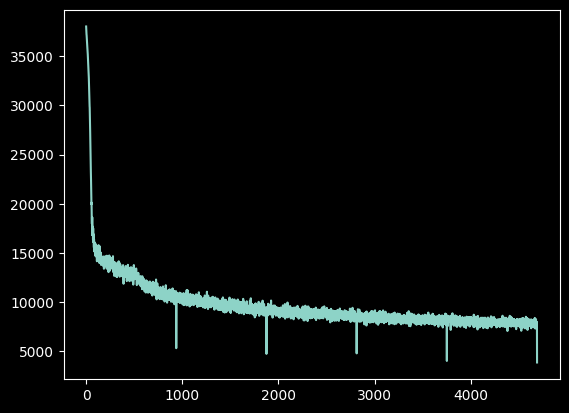

In [13]:
epochs = 5
outputs = []
losses = []

for epoch in range(epochs):
    for ( image,_ ) in data_loader:
        image = image.reshape(-1, 28*28).to("cuda")

        reconstructions = model(image)
        img_rec , mu , sigma = reconstructions

        rec_loss = loss_F(img_rec, image)
        kl_div = - 0.5  * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)

        loss = rec_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)

    outputs.append((epoch, image, reconstructions))
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

plt.style.use('dark_background')
losses = [x.cpu().detach().numpy() for x in losses]

plt.plot(losses)

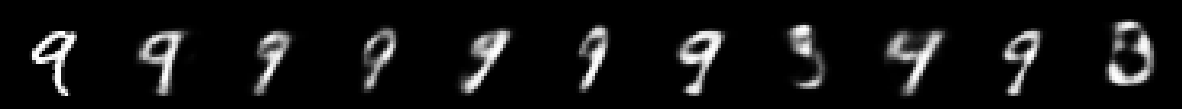

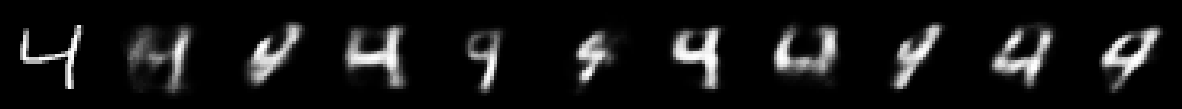

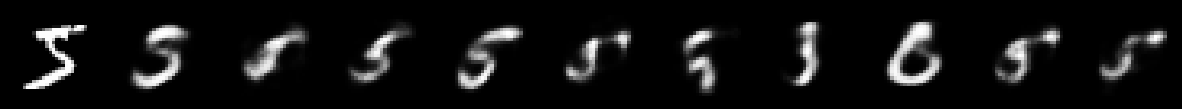

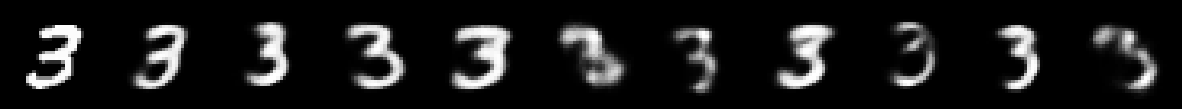

In [14]:
def inference(digit,dataset, num_samples=10):
    """ Reconstructs the given digit. """
    #load images with label digit
    images = [image for (image, label) in dataset if label == digit]
    #get mu and sigma
    images = torch.stack(images).to("cuda")
    mu, sigma = model.encoder(images.reshape(-1, 28*28))
    #sample from N(mu, sigma^2)
    epsilons = torch.randn_like(sigma)
    z = mu + epsilons * sigma
    #decode
    reconstructions = model.decoder(z)
    #return the reconstructions
    return reconstructions.reshape(-1, 28, 28).cpu().detach().numpy()

def plot_reconstructions(digit, dataset, n=10):
    # Plot the original images
    fig, axs = plt.subplots(1, n+1, figsize=(15, 2.5))
    images = [image for (image, label) in dataset if label == digit]
    for ax, img in zip(axs, images):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.axis('off')

    # Plot the reconstructions
    reconstructions = inference(digit, dataset, n)
    for ax, img in zip(axs[1:], reconstructions):
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.show()

plot_reconstructions(9, data_loader.dataset)
plot_reconstructions(4, data_loader.dataset)
plot_reconstructions(5, data_loader.dataset)
plot_reconstructions(3, data_loader.dataset)


In [15]:

tensot_transform = transforms.ToTensor()

custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
])

train_dataset = datasets.CelebA(root='data', split='valid', transform=custom_transforms, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

1443490838it [00:35, 40159265.61it/s] 
26721026it [00:00, 140331942.95it/s]
3424458it [00:00, 58450029.04it/s]
6082035it [00:00, 88060837.56it/s]
12156055it [00:00, 54778388.38it/s]
2836386it [00:00, 51559416.76it/s]


In [16]:
class Trim(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class conv_vae(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3,32,3,stride=2,padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.1,inplace=True),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(32,64,3,stride=2,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1,inplace=True),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(64,64,3,stride=2,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1,inplace=True),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(64,64,3,stride=2,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1,inplace=True),
            torch.nn.Dropout(0.25),
            torch.nn.Flatten()
        )


        self.z_mean = torch.nn.Linear(4096,200)
        self.z_sigma = torch.nn.Linear(4096,200)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(200,4096),
            torch.nn.Unflatten(1,(64,8,8)),

            torch.nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Dropout2d(0.25),
            #
            torch.nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Dropout2d(0.25),
            #
            torch.nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Dropout2d(0.25),
            #
            torch.nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
            #
            Trim(),  # 3x129x129 -> 3x128x128
            torch.nn.Sigmoid()
        )
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_sigma(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [17]:

model = conv_vae()
model.to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch: 1, Loss: 784563.1250
Epoch: 2, Loss: 740648.7500
Epoch: 3, Loss: 769095.6250
Epoch: 4, Loss: 732725.4375
Epoch: 5, Loss: 739343.1875


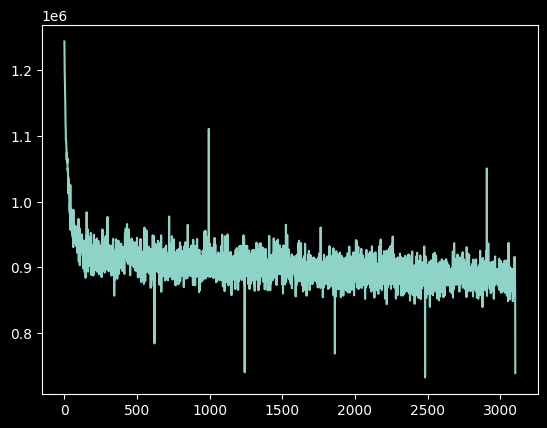

In [18]:
epochs = 5
outputs = []
losses = []
loss_F = torch.nn.BCELoss(reduction="sum")

for epoch in range(epochs):
    for ( image,_ ) in train_loader:
      image = image.to("cuda")
      reconstructions = model(image)
      enc, mu , sigma,img_rec = reconstructions

      rec_loss = loss_F(img_rec, image)
      kl_div = - 0.5  * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)

      loss = rec_loss + kl_div

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss)

    outputs.append((epoch, image, reconstructions))
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

plt.style.use('dark_background')
losses = [x.cpu().detach().numpy() for x in losses]

plt.plot(losses)

In [19]:
def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')



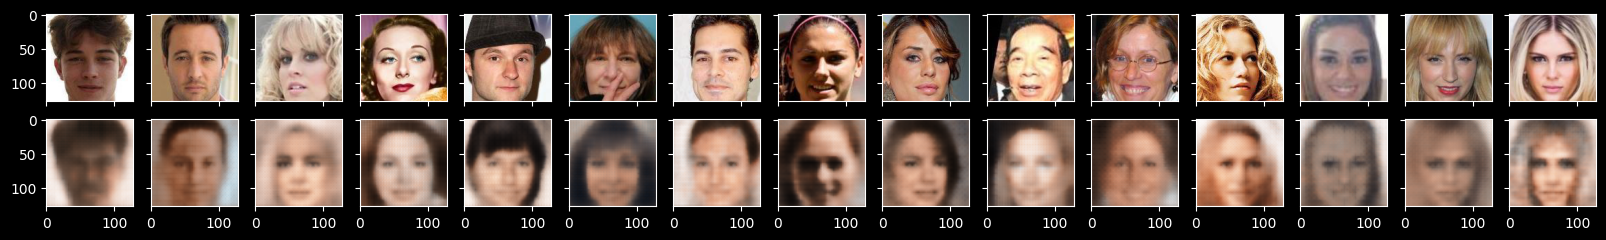

In [20]:
import numpy as np
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device="cuda",
                      modeltype='VAE')

In [21]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [38]:
device = "cuda"
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))
data_variance = np.var(training_data.data / 255.0)


Files already downloaded and verified
Files already downloaded and verified


In [23]:
class VecQua(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,comitment_cost):
        super(VecQua,self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.comitment_cost = comitment_cost
        #cookbook
        self.embedding = nn.Embedding(self.num_embeddings,self.embedding_dim)
        #uniform prior zero centerd
        self.embedding.weight.data.uniform_(-1/self.num_embeddings,1/self.num_embeddings)

    def forward(self,inputs):
        inputs = inputs.permute(0,2,3,1).contiguous()
        input_shape = inputs.shape

        flat_input = inputs.view(-1,self.embedding_dim)

        #calculate distances
        distances = (torch.sum(flat_input**2,dim=1,keepdim=True)
                    +torch.sum(self.embedding.weight**2,dim=1)
                    -2*torch.matmul(flat_input,self.embedding.weight.t()))

        #get encoding indices
        encoding_indices = torch.argmin(distances,dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0],self.num_embeddings).to(device)
        encodings.scatter_(1,encoding_indices,1)

        #quantize and unflatten
        quantized = torch.matmul(encodings,self.embedding.weight).view(input_shape)

        #loss
        e_latent_loss = F.mse_loss(quantized.detach(),inputs)
        q_latent_loss = F.mse_loss(quantized,inputs.detach())
        loss = q_latent_loss + self.comitment_cost*e_latent_loss

        #copying gradients
        quantized = inputs + (quantized-inputs).detach()
        avg_probs = torch.mean(encodings,dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs*torch.log(avg_probs+1e-10)))

        return loss,quantized.permute(0,3,1,2).contiguous(),perplexity,encodings

In [24]:
class Residual(nn.Module):
    def __init__(self,in_channels,num_hidden,num_residual_hiddens):
        super(Residual,self).__init__()

        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,out_channels=num_residual_hiddens,
                      kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,out_channels=num_hidden,
                      kernel_size=1,stride=1,bias=False)
        )

    def forward(self,x):
        #skip connection
        return x+self._block(x)

class ResidualStack(nn.Module):
    def __init__(self,in_channels,num_hidden,num_residual_layers,num_residual_hiddens):
        super(ResidualStack,self).__init__()
        self.num_residual_layers = num_residual_layers
        self.stack = nn.ModuleList([Residual(in_channels,num_hidden,num_residual_hiddens) for _ in range(self.num_residual_layers)])

    def forward(self,x):
        for i in range(self.num_residual_layers):
            x = self.stack[i](x)
        return F.relu(x)

In [25]:
class Encoder(nn.Module):
    def __init__(self,in_channels,num_hidden,num_residual_hidden,num_residual_layers):
        super(Encoder,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=num_hidden//2,kernel_size=4,stride=2,padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_hidden//2,out_channels=num_hidden,kernel_size=4,stride=2,padding=1)
        self.conv3 = nn.Conv2d(in_channels=num_hidden,out_channels=num_hidden,kernel_size=3,stride=1,padding=1)
        self.residual_stack = ResidualStack(in_channels=num_hidden,num_hidden=num_hidden,num_residual_layers=num_residual_layers,num_residual_hiddens=num_residual_hidden)

    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        return self.residual_stack(x)

In [26]:
class Decoder(nn.Module):
    def __init__(self,in_channels,num_hiddens,num_residual_layers,num_residual_hiddens):
        super(Decoder,self).__init__()

        self.conv1  = nn.Conv2d(in_channels=in_channels,out_channels=num_hiddens,kernel_size=3,stride=1,padding=1)
        self.residual_stack = ResidualStack(in_channels=num_hiddens,num_hidden=num_hiddens,num_residual_layers=num_residual_layers,num_residual_hiddens=num_residual_hiddens)
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=num_hiddens,out_channels=num_hiddens//2,kernel_size=4,stride=2,padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,out_channels=3,kernel_size=4,stride=2,padding=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.residual_stack(x)
        x = self.conv_trans1(x)
        x = F.relu(x)
        return self.conv_trans2(x)

In [31]:
batch_size = 32
num_training_updates = 9000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.0

learning_rate = 1e-3

In [39]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [29]:
class Model(nn.Module):
    def __init__(self,num_hiddens,num_residual_layers,num_residual_hiddens,embedding_dim,num_embeddings,commitment_cost):
        super(Model,self).__init__()
        self.encoder = Encoder(3,num_hiddens,num_residual_hiddens,num_residual_layers)
        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,out_channels=embedding_dim,kernel_size=1,stride=1)
        self.vq_vae = VecQua(num_embeddings,embedding_dim,commitment_cost)
        self.decoder = Decoder(embedding_dim,num_hiddens,num_residual_layers,num_residual_hiddens)

    def forward(self,x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        loss,quantized,perplexity,encodings = self.vq_vae(z)
        x_recon = self.decoder(quantized)
        return loss,x_recon,perplexity

In [41]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)


iterations: 100, Loss: 492.8633
recon_error: 0.756
perplexity: 1.685

iterations: 200, Loss: 110.5978
recon_error: 0.470
perplexity: 2.661

iterations: 300, Loss: 7.1265
recon_error: 0.408
perplexity: 4.025

iterations: 400, Loss: 7.5571
recon_error: 0.311
perplexity: 5.638

iterations: 500, Loss: 5.2168
recon_error: 0.313
perplexity: 5.155

iterations: 600, Loss: 5.4489
recon_error: 0.288
perplexity: 6.205

iterations: 700, Loss: 4.6526
recon_error: 0.277
perplexity: 6.524

iterations: 800, Loss: 3.3479
recon_error: 0.266
perplexity: 7.504

iterations: 900, Loss: 1.5319
recon_error: 0.249
perplexity: 9.228

iterations: 1000, Loss: 1.2956
recon_error: 0.230
perplexity: 12.215

iterations: 1100, Loss: 0.7664
recon_error: 0.216
perplexity: 15.957

iterations: 1200, Loss: 0.7147
recon_error: 0.206
perplexity: 19.237

iterations: 1300, Loss: 0.5922
recon_error: 0.198
perplexity: 22.334

iterations: 1400, Loss: 0.4901
recon_error: 0.190
perplexity: 25.534

iterations: 1500, Loss: 0.4366
rec

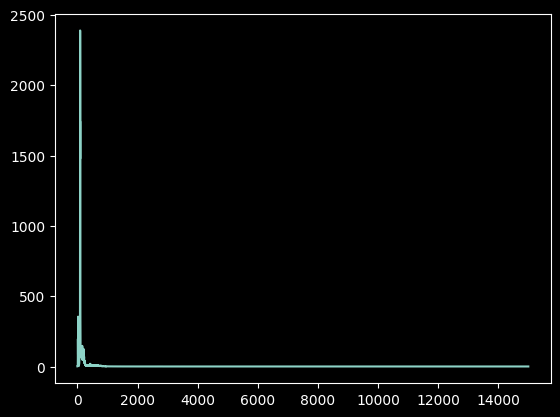

In [42]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
losses = []

for i in range(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss)
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print(f'iterations: {i+1}, Loss: {loss.item():.4f}')
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

plt.style.use('dark_background')
losses = [x.cpu().detach().numpy() for x in losses]

plt.plot(losses)

In [43]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model.pre_vq_conv(model.encoder(valid_originals))
_, valid_quantize, _, _ = model.vq_vae(vq_output_eval)
valid_reconstructions = model.decoder(valid_quantize)

In [44]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

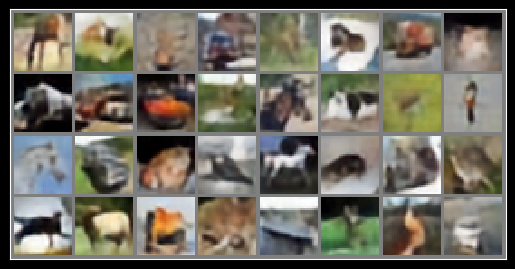

In [45]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )


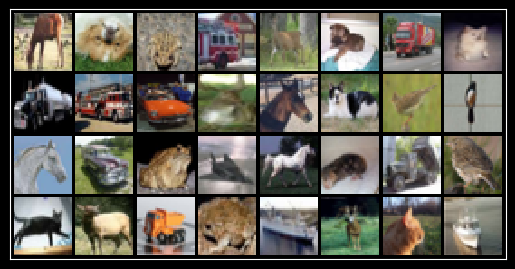

In [46]:
show(make_grid(valid_originals.cpu()+0.5))
